In [1]:
%matplotlib inline  

In [2]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pickle
import os
import warnings 
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import kernels, mean_functions
from Partial_stochasticity.Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Samplers.likelihoods import LikGaussian
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import MeasureSetGenerator
from Utilities.normalization import normalize_data
from Utilities.exp_utils import get_input_range
from Metrics.sampling import compute_rhat_regression
from Metrics import uncertainty as uncertainty_metrics
from Partial_stochasticity.Networks.mlp_masked import MLPMasked
from Partial_stochasticity.Networks.regression_net_masked import RegressionNetMasked
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Prior_optimization.wasserstein_mapper import MapperWasserstein
from Full_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization
from Full_stochasticity.Networks.regression_net import RegressionNet
from Full_stochasticity.Networks.mlp import MLP
from Utilities import util
from Utilities.priors import LogNormal

In [5]:
mpl.rcParams['figure.dpi'] = 100

In [6]:
SEED = 123
util.set_seed(SEED)

In [7]:
# Network architecture
n_units = 100
n_hidden = 1
activation_fn = "tanh"

In [8]:
# Dataset configurations
n_splits = 10
dataset = "boston"
data_dir = "./data/uci/regression"
noise_var = 0.1

In [9]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cpu 



# 1. Partially stochastic

## 1.1 Setup

In [10]:
out_dir_ps = "./exp/uci/boston/partially_stochastic"
util.ensure_dir(out_dir_ps)

## 1.2 Optimize the Prior

In [11]:
# Configurations for the prior optimization
D = 3
mapper_batch_size = 256                                         # The factorization depth
prior_opt_configurations = {
    "n_data": mapper_batch_size,                                # The batch size 
    "num_iters": 5000,                                          # The number of iterations of the prior optimization
    "lambd": (torch.tensor([0.25])/D).to(device),               # The regularization parameters for the layers
    "n_samples": 100,                                           # The number of function samples
    "lr": 5e-2,                                                 # The learning rate for the optimizer
    "print_every": 100,                                         # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                      # After how many epochs a checkpoint should be saved
}


In [12]:
masks_list = []
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir_ps, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    # Try the Exponential now
    kernel = kernels.Exponential(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)
    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
    kernel = kernel.to(device)
    # Initialize the GP model
    gp = GPR(X=torch.from_numpy(X_train_), Y=torch.from_numpy(y_train_).reshape([-1, 1]),
             kern=kernel, mean_function=mean)
    gp.likelihood.variance.set(noise_var)
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = FactorizedGaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, D = D, activation_fn=activation_fn, scaled_variance=True, device=device)
    mlp_reparam = mlp_reparam.to(device)
    # Perform optimization
    mapper = PriorOptimisationMapper(out_dir=saved_dir, device=device, gp = gp).to(device)
    p_hist, loss_hist = mapper.optimize(mlp_reparam, rand_generator, output_dim=output_dim, **prior_opt_configurations)
    path = os.path.join(saved_dir, "loss_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, loss_hist, fmt='%.6e')
    path = os.path.join(saved_dir, "pruned_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, p_hist, fmt='%.6e')
    print("----" * 20)
    masks_list.append(mlp_reparam.get_det_masks())
# Save the masks
with open(os.path.join(out_dir_ps, "masks_list.pkl"), "wb") as f:
    pickle.dump(masks_list, f)

Loading split 1 of boston dataset
>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 18.6128 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 14.0391 Number of pruned stochastic weights: 0
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 12.6533 Number of pruned stochastic weights: 0
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 13.7880 Number of pruned stochastic weights: 0
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 13.5090 Number of pruned stochastic weights: 1
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 15.7139 Number of pruned stochastic weights: 4
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 13.3852 Number of pruned stochastic weights: 10
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 12.9756 Number of pruned stochastic weights: 17
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 14.7950 Number of pruned stoch

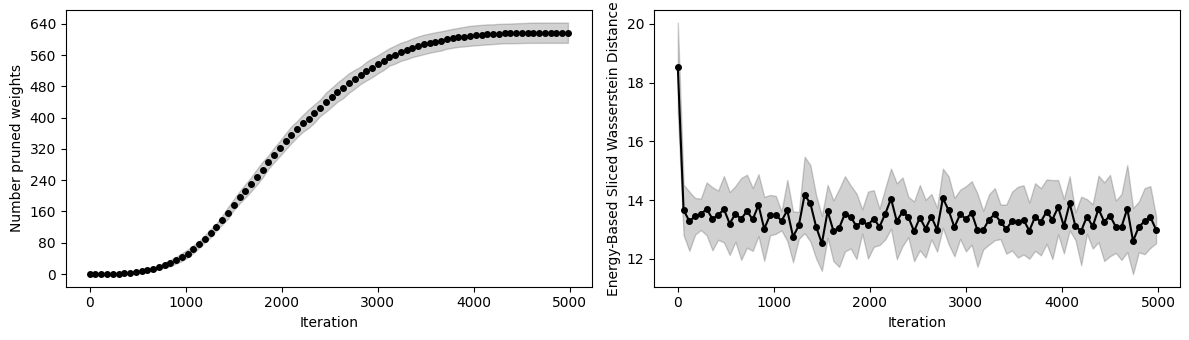

In [13]:
# Visualize the convergence
lossdist_data = []
pruned_vals_data = []
for i in range(0, n_splits):
    lossdist_file = os.path.join(out_dir_ps, str(i), "loss_values.log")
    pruned_vals_file = os.path.join(out_dir_ps, str(i), "pruned_values.log")
    lossdist_data.append(np.loadtxt(lossdist_file))
    pruned_vals_data.append(np.loadtxt(pruned_vals_file))

lossdist_vals = np.stack(lossdist_data)
pruned_vals = np.stack(pruned_vals_data)
indices = np.arange(prior_opt_configurations["num_iters"])[::60]
mean_loss = lossdist_vals.mean(0)
std_loss = lossdist_vals.std(0)
mean_pruned = pruned_vals.mean(0)
std_pruned = pruned_vals.std(0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, mean_pruned[indices], "ko", ms=4)
axes[0].fill_between(indices, mean_pruned[indices] - std_pruned[indices],
                 mean_pruned[indices] + std_pruned[indices], alpha=0.18, color="k")
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, mean_loss[indices], "-ko", ms=4)
axes[1].fill_between(indices, mean_loss[indices]-std_loss[indices],
                     mean_loss[indices]+std_loss[indices], alpha = 0.18, color = "k")
axes[1].set_ylabel("Energy-Based Sliced Wasserstein Distance")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## 1.3 Posterior Inference

In [ ]:
# SGHMC Hyper-parameters
sampling_configs_ps = {
    "batch_size": 16,            # Mini-batch size
    "num_samples": 40,           # Total number of samples for each chain
    "n_discarded": 10,           # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,   # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 2000,          # Thinning interval
    "lr": 0.02,                  # Step size
    "num_chains": 4,             # Number of chains
    "mdecay": 0.02,             # Momentum coefficient
    "print_every_n_samples": 5,  # After how many iterations an evaluation should be printed
    "lambd": 2e-8,               # The lambda for encouraging sparsity in the deterministic weights
    "train_det_before": 1000     # How many iterations the deterministic weights should be trained prior to sampling from the posterior
}
# Load the masks
with open(os.path.join(out_dir_ps, "masks_list.pkl"), "rb") as f:
    masks_list = pickle.load(f)

In [23]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir_ps, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, 
                    bias_mask, D = D, device = device)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir_ps, str(split_id), "ckpts", "ps-it-{}.ckpt".format(prior_opt_configurations["num_iters"]))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir_ps, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    # try out sam = True as well
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs_ps)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs_ps["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.2566e+00 RMSE = 1.8170e+00  
 Pruned deterministic weights: 0
Samples #    10 : NLL =  2.2441e+00 RMSE = 1.6543e+00  
 Pruned deterministic weights: 0
Samples #    15 : NLL =  2.2467e+00 RMSE = 1.6099e+00  
 Pruned deterministic weights: 0
Samples #    20 : NLL =  2.2501e+00 RMSE = 1.5798e+00  
 Pruned deterministic weights: 0
Samples #    25 : NLL =  2.2493e+00 RMSE = 1.5626e+00  
 Pruned deterministic weights: 0
Samples #    30 : NLL =  2.2500e+00 RMSE = 1.5541e+00  
 Pruned deterministic weights: 0
Chain: 2
Samples #    35 : NLL =  2.2490e+00 RMSE = 1.5025e+00  
 Pruned deterministic weights: 0
Samples #    40 : NLL =  2.2474e+00 RMSE = 1.4674e+00  
 Pruned deterministic weights: 0
Samples #    45 : NLL =  2.2475e+00 RMSE = 1.4516e+00  
 Pruned deterministic weights: 0
Samples #    50 : NLL =  2.2474e+00 RMSE = 1.4463e+00  
 Pruned deterministic weights: 0
Samples #    55 : NLL =  2.2484e+00 RMSE = 1.4530e+00  
 P

KeyboardInterrupt: 

In [ ]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(out_dir_ps, "optim_results.csv"), sep="\t", index=False)

# 2. Fully stochastic

## 2.1 Setup

In [ ]:
out_dir_fs = "./exp/uci/boston/fully_stochastic"
util.ensure_dir(out_dir_fs)

In [ ]:
num_iters = 200  # Number of iteterations of Wasserstein optimization
lr = 0.05        # The learning rate
n_samples = 128  # The mini-batch size

## 2.2 Optimize the prior

In [ ]:
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir_fs, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    kernel = kernels.RBF(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)

    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
        
    # Initialize the GP model
    gp = GPR(X=torch.from_numpy(X_train_), Y=torch.from_numpy(y_train_).reshape([-1, 1]),
             kern=kernel, mean_function=mean)
    gp.likelihood.variance.set(noise_var)
    
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = GaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, activation_fn, scaled_variance=True)
    
    mapper = MapperWasserstein(gp, mlp_reparam, rand_generator, out_dir=saved_dir,
                               output_dim=output_dim, n_data=100,
                               wasserstein_steps=(0, 200),
                               wasserstein_lr=0.02,
                               logger=None, wasserstein_thres=0.1,
                               n_gpu=0, gpu_gp=False)
    
    w_hist = mapper.optimize(num_iters=num_iters, n_samples=n_samples,
                             lr=lr, print_every=10, save_ckpt_every=10, debug=True)
    path = os.path.join(saved_dir, "wsr_values.log")
    np.savetxt(path, w_hist, fmt='%.6e')
    print("----" * 20)

Loading split 0 of boston dataset
>>> Iteration #   1: Wasserstein Dist 11.6952
>>> Iteration #  10: Wasserstein Dist 4.1593
>>> Iteration #  20: Wasserstein Dist 3.3999
>>> Iteration #  30: Wasserstein Dist 2.5832
>>> Iteration #  40: Wasserstein Dist 3.5168
>>> Iteration #  50: Wasserstein Dist 2.2596
>>> Iteration #  60: Wasserstein Dist 1.3891
>>> Iteration #  70: Wasserstein Dist 2.5701
>>> Iteration #  80: Wasserstein Dist 4.1510
>>> Iteration #  90: Wasserstein Dist 1.1122
>>> Iteration # 100: Wasserstein Dist 2.5505
>>> Iteration # 110: Wasserstein Dist 2.2983
>>> Iteration # 120: Wasserstein Dist 1.9809
>>> Iteration # 130: Wasserstein Dist 2.1367
>>> Iteration # 140: Wasserstein Dist 0.9242
>>> Iteration # 150: Wasserstein Dist -0.9928
>>> Iteration # 160: Wasserstein Dist 1.2591
>>> Iteration # 170: Wasserstein Dist 0.1687
>>> Iteration # 180: Wasserstein Dist 1.5402
>>> Iteration # 190: Wasserstein Dist 0.1206
>>> Iteration # 200: Wasserstein Dist 1.0632
Saved intermediate 

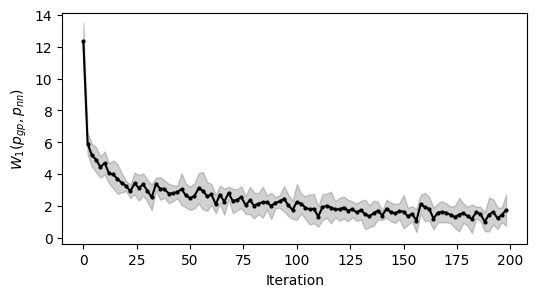

In [ ]:
# Visualize the convergence
wdist_data = []
for i in range(0, n_splits):
    wdist_file = os.path.join(out_dir_fs, str(i), "wsr_values.log")
    wdist_data.append(np.loadtxt(wdist_file))

wdist_vals = np.stack(wdist_data)
x = np.arange(wdist_vals.shape[1])
mean = wdist_vals.mean(0)
std = wdist_vals.std(0)

fig = plt.figure(figsize=(6, 3))
plt.plot(x[::2], mean[::2], "-ok", ms=2)
plt.fill_between(x[::2], mean[::2] - std[::2],
                 mean[::2] + std[::2], alpha=0.18, color="k")
plt.xlabel("Iteration")
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.show()

## 2.3 Posterior inference

In [ ]:
	
# Configure the SGHMC sampler
sampling_configs = {
    "batch_size": 32,
    "num_samples": 40,
    "n_discarded": 10,
    "num_burn_in_steps": 2000,
    "keep_every": 2000,
    "lr": 1e-2,
    "num_chains": 4,
    "mdecay": 1e-2,
    "print_every_n_samples": 5
}

In [ ]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id, dataset))
    saved_dir = os.path.join(out_dir_fs, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    
    # Initialize the neural network and likelihood modules
    net = MLP(input_dim, output_dim, [n_units] * n_hidden, activation_fn)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir_fs, str(split_id), "ckpts", "it-{}.ckpt".format(num_iters))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir_fs, str(split_id))
    bayes_net = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 0 of boston dataset
Chain: 0
Samples #     5 : NLL =  2.2853e+00 RMSE = 1.9573e+00 
Samples #    10 : NLL =  2.2713e+00 RMSE = 1.8236e+00 
Samples #    15 : NLL =  2.2700e+00 RMSE = 1.7992e+00 
Samples #    20 : NLL =  2.2655e+00 RMSE = 1.7623e+00 
Samples #    25 : NLL =  2.2622e+00 RMSE = 1.7342e+00 
Samples #    30 : NLL =  2.2626e+00 RMSE = 1.7245e+00 
Chain: 1
Samples #    35 : NLL =  2.2629e+00 RMSE = 1.7163e+00 
Samples #    40 : NLL =  2.2628e+00 RMSE = 1.7125e+00 
Samples #    45 : NLL =  2.2619e+00 RMSE = 1.7046e+00 
Samples #    50 : NLL =  2.2635e+00 RMSE = 1.7083e+00 
Samples #    55 : NLL =  2.2638e+00 RMSE = 1.7069e+00 
Samples #    60 : NLL =  2.2622e+00 RMSE = 1.6938e+00 
Chain: 2
Samples #    65 : NLL =  2.2625e+00 RMSE = 1.6964e+00 
Samples #    70 : NLL =  2.2630e+00 RMSE = 1.7007e+00 
Samples #    75 : NLL =  2.2642e+00 RMSE = 1.7074e+00 
Samples #    80 : NLL =  2.2644e+00 RMSE = 1.7087e+00 
Samples #    85 : NLL =  2.2644e+00 RMSE = 1.7091e+00 
Samp

FileNotFoundError: ./data/uci/regression/boston/original/index_train_8.txt not found.

In [ ]:
	
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(out_dir_fs, "optim_results.csv"), sep="\t", index=False)

## Comparison of the results

In [ ]:
result_df_fs = pd.read_csv(os.path.join(out_dir_fs, "optim_results.csv"), sep = "\t")
result_df_ps = pd.read_csv(os.path.join(out_dir_ps, "optim_results.csv"), sep = "\t")
print("Final result partially stochastic")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_ps['rmse'].mean()), float(result_df_ps['rmse'].std()),
        float(result_df_ps['nll'].mean()), float(result_df_ps['nll'].std())))
print("\nFinal result fully stochastic:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_fs['rmse'].mean()), float(result_df_fs['rmse'].std()),
        float(result_df_fs['nll'].mean()), float(result_df_fs['nll'].std())))

Final result
> RMSE: mean 2.8153e+00; std 7.4438e-01 | NLL: mean 2.5100e+00 std 1.3149e-01

Final results benchmark:
> RMSE: mean 2.7970e+00; std 9.1485e-01 | NLL: mean 2.4699e+00 std 1.4601e-01
